In [1]:
import pandas as pd
import numpy as np
import os
import fnmatch, re

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,pairwise_distances

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import pearsonr

In [2]:
def compute_error_rate(df):
    conf_mat = confusion_matrix(df["ground_truth"], df["Judgement.keys"], labels=["real", "fake"])
    row,_ = df.shape
    num_category = row/2
    print(row)
    real_err_rate = conf_mat[0,1]/num_category
    fake_err_rate = conf_mat[1,0]/num_category
    print(conf_mat)
    print("Error rate for real images:", real_err_rate)
    print("Error rate for fake images:", fake_err_rate)
    
    accuracy = accuracy_score(df["ground_truth"], df["Judgement.keys"])
    
    return accuracy, real_err_rate, fake_err_rate

def drop_demos(data):
    data = data.drop(range(0,3))
    data['ground_truth'] = data['ground_truth'].astype(int)
    data = data.replace(0,"fake")
    data = data.replace(1,"real")
    return data

def process_individual(file_path, file_name):
    participant_file_path = os.path.join(file_path, file_name)
    participant_data = pd.read_csv(participant_file_path)
    participant_data = drop_demos(participant_data)
    participant_data["result"] = participant_data.apply(lambda x: "correct" if x['ground_truth'] == x['Judgement.keys'] else "wrong", axis=1)
    data = participant_data[["Trial_num","image_name","image_path","ground_truth","Judgement.keys","result"]]
    rep1 = data.iloc[0:300]
    rep2 = data.iloc[300:]
    
    select_fake_rep1,_ = rep1[rep1["Judgement.keys"] == "fake"].shape
    #print(select_fake_rep1)
 
    select_fake_rep2,_ = rep2[rep2["Judgement.keys"] == "fake"].shape
    #print(select_fake_rep2)
    
    
    print("Repetition 1:")
    accuracy_rep1, real_err_rate_rep1, fake_err_rate_rep1 = compute_error_rate(rep1)
    print("Repetition 2:")
    accuracy_rep2, real_err_rate_rep2, fake_err_rate_rep2 = compute_error_rate(rep2)
    print("Overall:")
    accuracy_all, real_err_rate_all, fake_err_rate_all = compute_error_rate(data)

    
    wrong_rep1 = rep1[rep1["result"] == "wrong"]["image_name"]
    wrong_rep2 = rep2[rep2["result"] == "wrong"]["image_name"]

    wrong_in_both = list(set(wrong_rep1).intersection(wrong_rep2))
    print("Wrong in both:",len(wrong_in_both))
    
    encoded_misjudged = list(filter(lambda x: x.startswith('encoded'), wrong_in_both))
    
    real_misjudged = list(set(wrong_in_both) - set(encoded_misjudged))
    
    print("Number of encoded image been misjudged in both repetition:", len(encoded_misjudged)/150)
    print("Number of real image been misjudged in both repetition:", len(real_misjudged)/150)
    
    df_person = pd.DataFrame({'participant':file_name,
                              'real_err_rate_rep1':real_err_rate_rep1,
                              'fake_err_rate_rep1':fake_err_rate_rep1,
                              'real_err_rate_rep2':real_err_rate_rep2,
                              'fake_err_rate_rep2':fake_err_rate_rep2,
                              'real_err_rate_all':real_err_rate_all,
                              'fake_err_rate_all':fake_err_rate_all,
                              'accuracy_rep1': accuracy_rep1,
                              'accuracy_rep2': accuracy_rep2,
                              'accuracy_all': accuracy_all,
                              'select_fake_rep1':select_fake_rep1,
                              'select_fake_rep2':select_fake_rep2,
                              'real_misjudged_img_both_rep':[real_misjudged], 
                              'encoded_misjudged_img_both_rep':[encoded_misjudged], 
                              'num_real_misjudged_both_rep':len(real_misjudged),
                              'num_encoded_misjudged_both_rep':len(encoded_misjudged)}) 
    
    
    person_result = data[["result"]]
    
    return df_person, person_result


def process_all_people(file_path):
    files = list(filter(lambda f: os.path.isfile(os.path.join(file_path,f)), os.listdir(file_path)))

    df_stat = pd.DataFrame()
    
    trial_num_path = os.path.join(file_path, files[0])
    print(trial_num_path)
    
    aggregate = pd.read_csv(trial_num_path, usecols = ["Trial_num","image_name","image_path","ground_truth"])
    aggregate = drop_demos(aggregate)
    
    for person_data in files:
        if fnmatch.fnmatch(person_data, '*.csv'):
            df_person, person_result = process_individual(file_path, person_data)
            df_stat = df_stat.append(df_person, ignore_index=True)
            aggregate = pd.concat([aggregate, person_result], axis=1)
            print(aggregate)

    aggregate["all_res"] =  aggregate[aggregate.columns[4]].values.tolist()
    aggregate["num_correct"] = aggregate['all_res'].apply(lambda x: x.count("correct"))
    aggregate["num_wrong"] = aggregate['all_res'].apply(lambda x: x.count("wrong"))
    return df_stat,  aggregate 

In [4]:
## Read the data
data_path = "data/real-fake-judgment-good-data"
all_people_real_fake, aggregate_result = process_all_people(data_path)

data/real-fake-judgment-good-data/Lajja Desai_Real-fake-judgement-flashing-group1_2022_Mar_25_1626.csv
Repetition 1:
300
[[109  41]
 [ 48 102]]
Error rate for real images: 0.2733333333333333
Error rate for fake images: 0.32
Repetition 2:
300
[[94 56]
 [67 83]]
Error rate for real images: 0.37333333333333335
Error rate for fake images: 0.44666666666666666
Overall:
600
[[203  97]
 [115 185]]
Error rate for real images: 0.3233333333333333
Error rate for fake images: 0.38333333333333336
Wrong in both: 49
Number of encoded image been misjudged in both repetition: 0.18
Number of real image been misjudged in both repetition: 0.14666666666666667
       Trial_num                                         image_path  \
3      Trial # 1  Group1-stimuli/group1-block1/real-group1-b1/Gr...   
4      Trial # 2  Group1-stimuli/group1-block1/fake-group2-b1/en...   
5      Trial # 3  Group1-stimuli/group1-block1/real-group1-b1/Gr...   
6      Trial # 4  Group1-stimuli/group1-block1/real-group1-b1/Gr...   

600
[[253  47]
 [ 18 282]]
Error rate for real images: 0.15666666666666668
Error rate for fake images: 0.06
Wrong in both: 14
Number of encoded image been misjudged in both repetition: 0.006666666666666667
Number of real image been misjudged in both repetition: 0.08666666666666667
       Trial_num                                         image_path  \
3      Trial # 1  Group1-stimuli/group1-block1/real-group1-b1/Gr...   
4      Trial # 2  Group1-stimuli/group1-block1/fake-group2-b1/en...   
5      Trial # 3  Group1-stimuli/group1-block1/real-group1-b1/Gr...   
6      Trial # 4  Group1-stimuli/group1-block1/real-group1-b1/Gr...   
7      Trial # 5  Group1-stimuli/group1-block1/fake-group2-b1/en...   
..           ...                                                ...   
598  Trial # 146  Group1-stimuli/group1-block2/fake-group2-b2/en...   
599  Trial # 147  Group1-stimuli/group1-block2/real-group1-b2/Gr...   
600  Trial # 148  Group1-stimuli/group1-block2/real-group1-b2/Gr...   
601  Tri

       Trial_num                                         image_path  \
3      Trial # 1  Group1-stimuli/group1-block1/real-group1-b1/Gr...   
4      Trial # 2  Group1-stimuli/group1-block1/fake-group2-b1/en...   
5      Trial # 3  Group1-stimuli/group1-block1/real-group1-b1/Gr...   
6      Trial # 4  Group1-stimuli/group1-block1/real-group1-b1/Gr...   
7      Trial # 5  Group1-stimuli/group1-block1/fake-group2-b1/en...   
..           ...                                                ...   
598  Trial # 146  Group1-stimuli/group1-block2/fake-group2-b2/en...   
599  Trial # 147  Group1-stimuli/group1-block2/real-group1-b2/Gr...   
600  Trial # 148  Group1-stimuli/group1-block2/real-group1-b2/Gr...   
601  Trial # 149  Group1-stimuli/group1-block2/fake-group2-b2/en...   
602  Trial # 150  Group1-stimuli/group1-block2/fake-group2-b2/en...   

    ground_truth                   image_name   result   result   result  \
3           real          Group1_IMG_0022.jpg  correct  correct    wron

Repetition 1:
300
[[114  36]
 [ 54  96]]
Error rate for real images: 0.24
Error rate for fake images: 0.36
Repetition 2:
300
[[121  29]
 [ 65  85]]
Error rate for real images: 0.19333333333333333
Error rate for fake images: 0.43333333333333335
Overall:
600
[[235  65]
 [119 181]]
Error rate for real images: 0.21666666666666667
Error rate for fake images: 0.39666666666666667
Wrong in both: 46
Number of encoded image been misjudged in both repetition: 0.22
Number of real image been misjudged in both repetition: 0.08666666666666667
       Trial_num                                         image_path  \
3      Trial # 1  Group1-stimuli/group1-block1/real-group1-b1/Gr...   
4      Trial # 2  Group1-stimuli/group1-block1/fake-group2-b1/en...   
5      Trial # 3  Group1-stimuli/group1-block1/real-group1-b1/Gr...   
6      Trial # 4  Group1-stimuli/group1-block1/real-group1-b1/Gr...   
7      Trial # 5  Group1-stimuli/group1-block1/fake-group2-b1/en...   
..           ...                        

,participant,real_err_rate_rep1,fake_err_rate_rep1,real_err_rate_rep2,fake_err_rate_rep2,real_err_rate_all,fake_err_rate_all,accuracy_rep1,accuracy_rep2,accuracy_all,select_fake_rep1,select_fake_rep2,real_misjudged_img_both_rep,encoded_misjudged_img_both_rep,num_real_misjudged_both_rep,num_encoded_misjudged_both_rep
0,Lajja Desai_Real-fake-judgement-flashing-group...,0.273333,0.320000,0.373333,0.446667,0.323333,0.383333,0.703333,0.590000,0.646667,143,139,"[Group1_IMG_9833.jpg, Group1_IMG_9786.jpg, Gro...","[encoded_Group2_IMG_0225.jpg, encoded_Group2_I...",22,27
1,Naomi Tewodros_Real-fake-judgement-flashing-gr...,0.193333,0.220000,0.213333,0.320000,0.203333,0.270000,0.793333,0.733333,0.763333,146,134,"[Group1_IMG_0172.jpg, Group1_IMG_9704.jpg, Gro...","[encoded_Group2_IMG_0365.jpg, encoded_Group2_I...",14,16
2,Jamie Minden_Real-fake-judgement-flashing-grou...,0.160000,0.186667,0.080000,0.240000,0.120000,0.213333,0.826667,0.840000,0.833333,146,126,"[Group1_IMG_1095.jpg, Group1_IMG_1029.jpg, Gro...","[encoded_Group2_IMG_0355.jpg, encoded_Group2_I...",6,13
3,Orion Freed_Real-fake-judgement-flashing-group...,0.560000,0.373333,0.533333,0.380000,0.546667,0.376667,0.533333,0.543333,0.538333,178,173,"[Group1_IMG_1095.jpg, Group1_IMG_0519.jpg, Gro...","[encoded_Group2_IMG_0412.jpg, encoded_Group2_I...",56,29
4,Nathan Surmeian_Real-fake-judgement-flashing-g...,0.406667,0.286667,0.340000,0.300000,0.373333,0.293333,0.653333,0.680000,0.666667,168,156,"[Group1_IMG_0187.jpg, Group1_IMG_0252.jpg, Gro...","[encoded_Group2_IMG_0398.jpg, encoded_Group2_I...",30,19
5,Malcolm Going_Real-fake-judgement-flashing-gro...,0.286667,0.153333,0.200000,0.133333,0.243333,0.143333,0.780000,0.833333,0.806667,170,160,"[Group1_IMG_1029.jpg, Group1_IMG_4253.jpg, Gro...","[encoded_Group2_IMG_0355.jpg, encoded_Group2_I...",14,5
6,sarah ribaudo_Real-fake-judgement-flashing-gro...,0.193333,0.346667,0.133333,0.393333,0.163333,0.370000,0.730000,0.736667,0.733333,127,111,"[Group1_IMG_0329.jpg, Group1_IMG_0252.jpg, Gro...","[encoded_Group2_IMG_9909.jpg, encoded_Group2_I...",10,29
7,Alyssa Jones_Real-fake-judgement-flashing-grou...,0.220000,0.306667,0.140000,0.286667,0.180000,0.296667,0.736667,0.786667,0.761667,137,128,"[Group1_IMG_0428.jpg, Group1_IMG_9704.jpg, Gro...","[encoded_Group2_IMG_0176.jpg, encoded_Group2_I...",13,15
8,Zehao Yu_Real-fake-judgement-flashing-group1_2...,0.140000,0.100000,0.173333,0.020000,0.156667,0.060000,0.880000,0.903333,0.891667,156,173,"[Group1_IMG_1095.jpg, Group1_IMG_1029.jpg, Gro...",[encoded_Group2_IMG_8390.jpg],13,1
9,Jack Whitcomb_Real-fake-judgement-flashing-gro...,0.193333,0.193333,0.046667,0.173333,0.120000,0.183333,0.806667,0.890000,0.848333,150,131,"[Group1_IMG_9833.jpg, Group1_IMG_9889.jpg, Gro...","[encoded_Group2_IMG_0155.jpg, encoded_Group2_I...",3,6


# Plot Error rate for each observer

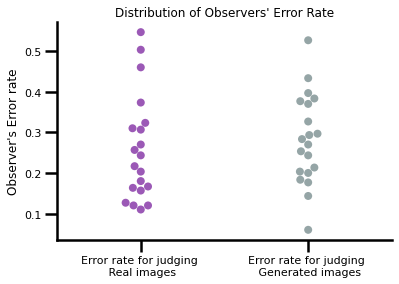

In [5]:
sns.set_context(context='poster', font_scale=0.5)

data_for_boxplot = [all_people_real_fake['real_err_rate_all'], all_people_real_fake['fake_err_rate_all']]
fig1, ax1 = plt.subplots()
labels = ["Error rate for judging \n Real images", "Error rate for judging \n Generated images"]


ax1 = sns.swarmplot(data=data_for_boxplot,  palette=["#9b59b6", "#95a5a6"], size = 8)

sns.despine()

ax1.set_title("Distribution of Observers' Error Rate")
ax1.set_xticklabels(labels)
ax1.set_ylabel("Observer's Error rate")
plt.show()

In [6]:
##Define color map

real_fake_color_palette = dict(real="#9b59b6", fake="#95a5a6")
#real_fake_color_palette = dict(real="#1f85be", fake="#f56c3f")

real_fake_hue_order = ["real","fake"]

In [8]:
## Add percent wrong column

aggregate_result["percent_wrong"] = aggregate_result["num_wrong"] / (aggregate_result["num_wrong"] + aggregate_result["num_correct"])

aggregate_result["percent_correct"] = 1 - aggregate_result["percent_wrong"]

rep = 300 * ["Rep 1"] + 300 * ["Rep 2"]

aggregate_result["Repeat"] = rep


In [15]:
## Splits 2 repeats. Match the 2nd repeat to first
rep1 = aggregate_result.iloc[0:300]
rep2 = aggregate_result.iloc[300:]

rep2 = rep2.set_index('image_name')
rep2 = rep2.reindex(index=rep1['image_name'])
rep2 = rep2.reset_index()

# Show aggregated error for fake and real judgement

In [10]:
aggregate_result.groupby("ground_truth").sum()/6000

,num_correct,num_wrong,percent_wrong,percent_correct
ground_truth,,,,
fake,0.718333,0.281667,0.014083,0.035917
real,0.742167,0.257833,0.012892,0.037108


In [11]:
rep1.groupby("ground_truth").sum()/3000

,num_correct,num_wrong,percent_wrong,percent_correct
ground_truth,,,,
fake,0.721333,0.278667,0.013933,0.036067
real,0.724333,0.275667,0.013783,0.036217


In [12]:
rep2.groupby("ground_truth").sum()/3000

,num_correct,num_wrong,percent_wrong,percent_correct
ground_truth,,,,
fake,0.715333,0.284667,0.014233,0.035767
real,0.760000,0.240000,0.012000,0.038000


# Plot distribution of error

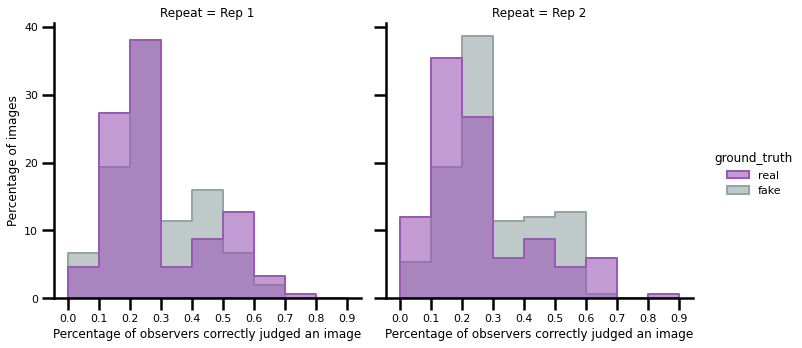

In [14]:
plot_error_image = sns.displot(aggregate_result, x="percent_wrong", hue="ground_truth", col="Repeat", stat="percent", alpha=0.6,
                               element="step", binwidth=0.1, common_norm=False, fill=True,
                               hue_order=real_fake_hue_order,palette=real_fake_color_palette)
plot_error_image.set(xticks=np.arange(0,1,0.1), yticks=np.arange(0,50,10))
plot_error_image.set(xlabel='Percentage of observers correctly judged an image', ylabel='Percentage of images')